# Big Data in Finance: Part IV <BR><BR> Lecture Notes 2: CRSP 
    
**Instructor** <BR>
Kirsten Burr, kburr26@gsb.columbia.edu
    
**TA's:** <BR>
Dian Jiao, dj2526@columbia.edu <BR>
Varuun Deshpande, vdeshpande25@gsb.columbia.edu
    
<sub> Credit: lecture notes originally developed by Lira Mota

**Objectives:** <BR>
1. Download and understand the basics of CRSP tables:
    1. Monthly Stock Files (MSF)
    2. Monthly Stock Events (MSE)
    2. Risk free rates (MCTI)

2. Create one data frame with the following variables:
    1. Stock exchange code
    2. Security code 
    3. Stock monthly returns
    4. Market Equity Value (AMT*PRC)
    5. Risk Free Rate

    
3. Add variables:
    1. Rankyear - Fama and French yearly rebalancing schedule
    2. Returns adjusted for delisting
    3. ME by PERMCO
    4. ME lag (used for portfolios weights)
    5. Cumulative past 11 months returns (used to calculate momentum portfolios - homework 2)

## Set Up

In [1]:
%matplotlib inline 

# Packages 
import wrds
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]

import time
from time import strptime, strftime

# Setups
pd.set_option("display.max_rows", 200) # max number or rows to be displayed 

In [2]:
# Set WRDS Connection
db = wrds.Connection(wrds_username='khardnett') # make sure to configure wrds connector before hand.   

Loading library list...
Done


## How is the CRSP data organized?

In [3]:
libs = db.list_libraries()
# Transform crsp_tables to a Pandas data frame to have a better display.
libs = pd.DataFrame({'libs':libs}).sort_values('libs').reset_index(drop=True) 
libs.head(100)

,libs
0,aha_sample
1,ahasamp
2,audit
3,audit_acct_os
4,audit_audit_comp
5,audit_common
6,audit_corp_legal
7,auditsmp
8,auditsmp_all
9,bank


In [4]:
libs.shape

(371, 1)

### All tables in CRSPQ

In [5]:
# crspq: CRSP quartely update
crsp_tables = db.list_tables(library="crspq") 
# crspm: CRSP monthly update - not included in our subscription

# Transform crsp_tables to a Pandas data frame to have a better display.
crsp_tables = pd.DataFrame({'tables':crsp_tables}).sort_values('tables').reset_index(drop=True)  
crsp_tables.head(150) 

,tables
0,acti
1,asia
2,asib
3,asic
4,asio
5,asix
6,bmdebt
7,bmheader
8,bmpaymts
9,bmquotes


In [6]:
crsp_tables.shape

(387, 1)

We are going to focus on three tables:

1. MSF: Monthly Stock Files 
2. MSE: Monthly Stock Events 
3. MCTI: US Treasury and Inflation - Monthly

Nice overview can be found [here](https://wrds-www.wharton.upenn.edu/pages/support/manuals-and-overviews/crsp/stocks-and-indices/overview-crsp-us-stock-database/).

### Primary Keys (PK)

* Company identifier: PERMCO
* Security identifier: PERMNO
* Date: monthly or daily

## The Stock/Securities Files Table (msf or dsf)

### All Variables in MSF

In [7]:
db.describe_table(library="crsp", table="msf")

Approximately 5150989 rows in crsp.msf.


,name,nullable,type,comment
0,cusip,True,VARCHAR(8),CUSIP Header
1,permno,True,INTEGER,PERMNO
2,permco,True,INTEGER,PERMCO
3,issuno,True,INTEGER,Nasdaq Issue Number
4,hexcd,True,SMALLINT,Exchange Code Header
5,hsiccd,True,INTEGER,Standard Industrial Classification Code Header
6,date,True,DATE,Date of Observation
7,bidlo,True,"NUMERIC(11, 5)",Bid or Low Price
8,askhi,True,"NUMERIC(11, 5)",Ask or High Price
9,prc,True,"NUMERIC(11, 5)",Price or Bid/Ask Average


### Extra Identifiers: names table

In [8]:
db.describe_table(library="crsp", table="stocknames")

Approximately 79523 rows in crsp.stocknames.


,name,nullable,type,comment
0,permno,True,INTEGER,PERMNO
1,namedt,True,DATE,None
2,nameenddt,True,DATE,None
3,shrcd,True,SMALLINT,Share Code as of Name Start Date
4,exchcd,True,SMALLINT,Exchange Code
5,siccd,True,INTEGER,SIC Code as of Name Start Date
6,ncusip,True,VARCHAR(8),CUSIP
7,ticker,True,VARCHAR(8),Ticker Symbol
8,comnam,True,VARCHAR(35),Company Name
9,shrcls,True,VARCHAR(4),Share Class as of Name Start Date


### Which firm identifier to use?

* PERMCO?
* PERMNO?
* CUSIP?
* NCUSIP?
* TICKER?

In [9]:
## An explample of name change
names_table = db.raw_sql('SELECT * FROM crsp.stocknames')

In [10]:
# Google
# names_table[names_table.permno==14542]
names_table[(names_table.ticker=='GOOG')| (names_table.ticker=='GOOGL')].sort_values('namedt')

,permno,namedt,nameenddt,shrcd,exchcd,siccd,ncusip,ticker,comnam,shrcls,permco,hexcd,cusip,st_date,end_date,namedum
76512,90319,2004-08-19,2014-04-02,11,3,7375,38259P50,GOOG,GOOGLE INC,A,45483,3,02079K30,2004-08-19,2024-12-31,2.0
9712,14542,2014-04-03,2015-10-04,11,3,7375,38259P70,GOOG,GOOGLE INC,C,45483,3,02079K10,2014-04-03,2024-12-31,2.0
76513,90319,2014-04-03,2015-10-04,11,3,7375,38259P50,GOOGL,GOOGLE INC,A,45483,3,02079K30,2004-08-19,2024-12-31,2.0
9713,14542,2015-10-05,2024-12-31,11,3,7375,02079K10,GOOG,ALPHABET INC,C,45483,3,02079K10,2014-04-03,2024-12-31,2.0
76514,90319,2015-10-05,2024-12-31,11,3,7375,02079K30,GOOGL,ALPHABET INC,A,45483,3,02079K30,2004-08-19,2024-12-31,2.0


In [11]:
# Berkshire Hathaway
names_table[names_table.comnam.str.contains('BERKSHIRE HATHAWAY')].sort_values('namedt')

,permno,namedt,nameenddt,shrcd,exchcd,siccd,ncusip,ticker,comnam,shrcls,permco,hexcd,cusip,st_date,end_date,namedum
15186,17778,1976-10-14,1986-03-31,11,3,6711,08467010,BKHT,BERKSHIRE HATHAWAY INC DEL,None,540,1,08467010,1976-10-14,2024-12-31,2.0
15187,17778,1986-04-01,1988-11-28,11,3,6610,08467010,BKHT,BERKSHIRE HATHAWAY INC DEL,None,540,1,08467010,1976-10-14,2024-12-31,2.0
15188,17778,1988-11-29,1996-05-08,11,1,6331,08467010,BRK,BERKSHIRE HATHAWAY INC DEL,None,540,1,08467010,1976-10-14,2024-12-31,2.0
15189,17778,1996-05-09,2016-12-18,11,1,6331,08467010,BRK,BERKSHIRE HATHAWAY INC DEL,A,540,1,08467010,1976-10-14,2024-12-31,2.0
64001,83443,1996-05-09,2010-01-20,11,1,6331,08467020,BRK,BERKSHIRE HATHAWAY INC DEL,B,540,1,08467070,1996-05-09,2024-12-31,2.0
64002,83443,2010-01-21,2016-12-18,11,1,6331,08467070,BRK,BERKSHIRE HATHAWAY INC DEL,B,540,1,08467070,1996-05-09,2024-12-31,2.0
15190,17778,2016-12-19,2021-04-04,11,1,6371,08467010,BRK,BERKSHIRE HATHAWAY INC DEL,A,540,1,08467010,1976-10-14,2024-12-31,2.0
64003,83443,2016-12-19,2021-04-04,11,1,6371,08467070,BRK,BERKSHIRE HATHAWAY INC DEL,B,540,1,08467070,1996-05-09,2024-12-31,2.0
15191,17778,2021-04-05,2024-12-31,11,1,6331,08467010,BRK,BERKSHIRE HATHAWAY INC DEL,A,540,1,08467010,1976-10-14,2024-12-31,2.0
64004,83443,2021-04-05,2024-12-31,11,1,6331,08467070,BRK,BERKSHIRE HATHAWAY INC DEL,B,540,1,08467070,1996-05-09,2024-12-31,2.0


In [12]:
# HP
names_table[names_table.permno==32707]


,permno,namedt,nameenddt,shrcd,exchcd,siccd,ncusip,ticker,comnam,shrcls,permco,hexcd,cusip,st_date,end_date,namedum
31029,32707,1962-07-02,1963-03-19,11,2,1311,None,HP,HELMERICH & PAYNE INC,None,20902,1,42345210,1962-07-02,2024-12-31,2.0
31030,32707,1963-03-20,1968-01-01,11,1,1311,None,HP,HELMERICH & PAYNE INC,None,20902,1,42345210,1962-07-02,2024-12-31,2.0
31031,32707,1968-01-02,2011-06-09,11,1,1311,42345210,HP,HELMERICH & PAYNE INC,None,20902,1,42345210,1962-07-02,2024-12-31,2.0
31032,32707,2011-06-10,2024-12-31,11,1,1381,42345210,HP,HELMERICH & PAYNE INC,None,20902,1,42345210,1962-07-02,2024-12-31,2.0


In [13]:
# One permco, multiple permno, multiple cusip

# AT&T
names_table[names_table.permco==20103]

,permno,namedt,nameenddt,shrcd,exchcd,siccd,ncusip,ticker,comnam,shrcls,permco,hexcd,cusip,st_date,end_date,namedum
1043,10401,1925-12-31,1962-07-01,11,1,4810,None,None,AMERICAN TELEPHONE & TELEG CO,None,20103,1,00195750,1925-12-31,2005-11-18,2.0
1044,10401,1962-07-02,1968-01-01,11,1,4811,None,T,AMERICAN TELEPHONE & TELEG CO,None,20103,1,00195750,1925-12-31,2005-11-18,2.0
1045,10401,1968-01-02,1994-04-20,11,1,4811,03017710,T,AMERICAN TELEPHONE & TELEG CO,None,20103,1,00195750,1925-12-31,2005-11-18,2.0
1046,10401,1994-04-21,2001-02-28,11,1,4812,00195710,T,A T & T CORP,None,20103,1,00195750,1925-12-31,2005-11-18,2.0
1047,10401,2001-03-01,2002-11-18,11,1,4813,00195710,T,A T & T CORP,None,20103,1,00195750,1925-12-31,2005-11-18,2.0
1048,10401,2002-11-19,2005-11-18,11,1,4813,00195750,T,A T & T CORP,None,20103,1,00195750,1925-12-31,2005-11-18,2.0
69947,86746,1999-03-10,2001-02-28,11,1,4812,00195720,LMG,A T & T CORP,A,20103,1,00195720,1999-03-10,2001-08-09,2.0
69948,86746,2001-03-01,2001-08-09,11,1,4813,00195720,LMG,A T & T CORP,A,20103,1,00195720,1999-03-10,2001-08-09,2.0
69949,86747,1999-03-10,2001-02-28,11,1,4812,00195730,LMG,A T & T CORP,B,20103,1,00195730,1999-03-10,2001-08-09,2.0
69950,86747,2001-03-01,2001-08-09,11,1,4813,00195730,LMG,A T & T CORP,B,20103,1,00195730,1999-03-10,2001-08-09,2.0


### Difference between header information and historical information

* Usually "h" in CRSP means header - a static characteristic. Either the most recent observation (hsiccd) or as the time the security was listed (hexcd).
* Historical data: siccd, excd, etc.
* Notice that for CUSIP it is different. Historical cusip is under NCUSIP.

### Variables of interest

1. Identifiers: date, permno, permco
2. Price: prc
3. Return: ret
4. Return Ex-dividend: retx
5. Factor to adjust prices and shares outstading: 'cfacpr'/'cfacshr'


Where to find variable definitions? [WRDS website](https://wrds-www.wharton.upenn.edu/documents/396/CRSP_US_Stock_Indices_Data_Descriptions.pdf).


In [14]:
sfvars = ['prc','vol','ret', 'retx','cfacpr','cfacshr']
query = """SELECT date, permno, permco, {} 
           FROM crsp.msf
           WHERE date>='1980-01-01'""".format(', '.join(sfvars))
print(query)

SELECT date, permno, permco, prc, vol, ret, retx, cfacpr, cfacshr 
           FROM crsp.msf
           WHERE date>='1980-01-01'


In [15]:
msf_data = db.raw_sql(query, date_cols=['date'])
del(sfvars, query) 

**Look at the data**

In [16]:
msf_data.head()

,date,permno,permco,prc,vol,ret,retx,cfacpr,cfacshr
0,1980-01-31,10006,22156,41.500,5903.0,0.211679,0.211679,1.0,1.0
1,1980-01-31,10057,20020,33.500,1965.0,0.282297,0.282297,1.0,1.0
2,1980-01-31,10058,20,-2.500,NaN,0.000000,0.000000,1.0,1.0
3,1980-01-31,10065,20023,12.875,2221.0,0.099216,0.061569,1.5,1.5
4,1980-01-31,10103,52,-1.625,NaN,0.083333,0.083333,1.0,1.0


In [17]:
# Check if we have a primary key
msf_data.duplicated(subset=['permno', 'date']).sum()

0

In [18]:
msf_data.groupby(['permco', 'date']).permno.nunique().mean()  

1.1115994078608324

In [19]:
msf_data.groupby(['permco', 'date']).permno.nunique().max() 

351

<Axes: title={'center': 'Cumulative Returns of Apple'}, xlabel='date'>

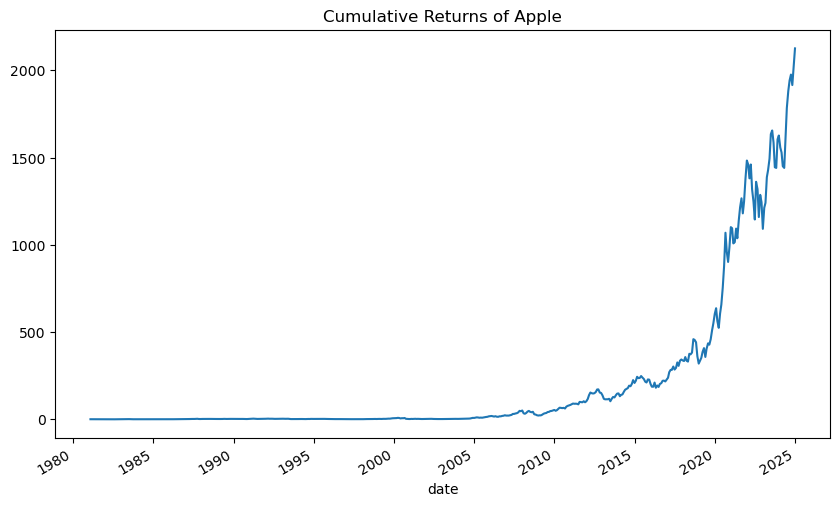

In [20]:
# Cumulative returns of Apple 
apple_ret = msf_data[msf_data.permno==14593].set_index(['date']).ret
((1+apple_ret).cumprod()).plot(title='Cumulative Returns of Apple')  

<Axes: title={'center': 'Cumulative Returns of Apple'}, xlabel='date'>

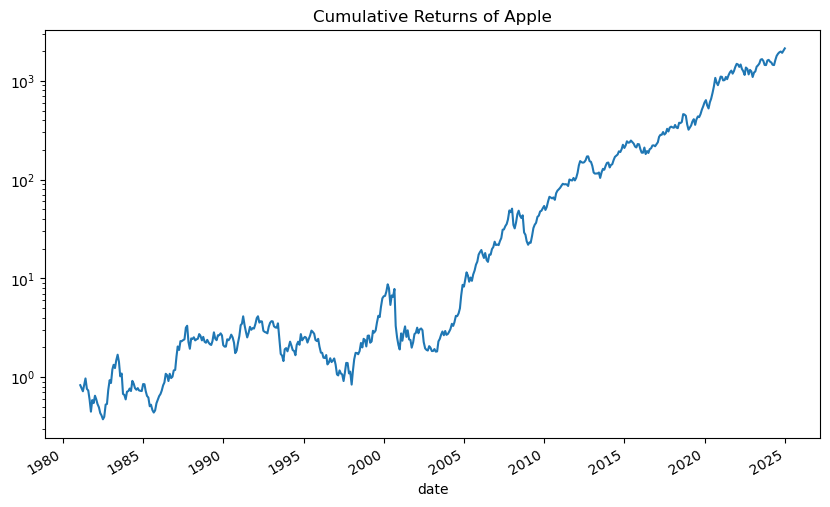

In [21]:
# Cumulative returns of Apple 
apple_ret = msf_data[msf_data.permno==14593].set_index(['date']).ret
((1+apple_ret).cumprod()).plot(title='Cumulative Returns of Apple', logy=True)  

## The Stock/Security Events (mse, mseall, dse, dseall) 

### All variables in MSEALL

In [22]:
# Loot at columns you could download 
db.describe_table(library="crsp", table="mseall")

Approximately 3744798 rows in crsp.mseall.


,name,nullable,type,comment
0,date,True,DATE,Date of Observation
1,comnam,True,VARCHAR(32),Company Name
2,cusip,True,VARCHAR(8),CUSIP Identifier
3,dclrdt,True,DATE,Declaration Date
4,dlamt,True,"NUMERIC(11, 5)",Amount After Delisting
5,dlpdt,True,DATE,Date of Delisting Payment
6,dlstcd,True,SMALLINT,Delisting Code
7,hsiccd,True,INTEGER,Header SIC Cde
8,issuno,True,INTEGER,Nasdaq Issue Identifier
9,ncusip,True,VARCHAR(8),Names CUSIP


### Variables of Interest 
1. Delisting returns: dlret, dlretx
2. Exchange codes: exchcd - 1 (NYSE), 2 (NYSE MKT), 3 (NASDAQ), 4 (Arca) or 5 (Bats).
3. Share Type Code: shrcd (usually we only look at Ordinary Common Shares, 10 and 11)
4. Industry classifications: siccd, naics
5. Stock Ticker


In [23]:
msevars = ['distcd','dlret', 'dlretx', 'exchcd','naics', 'ncusip', 'shrcd', 'shrout', 
           'siccd','comnam','ticker']
query = """SELECT date, permno, permco, {} 
           FROM crsp.mseall
           WHERE date>='1980-01-01'""".format(', '.join(msevars))
print(query) 

SELECT date, permno, permco, distcd, dlret, dlretx, exchcd, naics, ncusip, shrcd, shrout, siccd, comnam, ticker 
           FROM crsp.mseall
           WHERE date>='1980-01-01'


In [24]:
mse_data = db.raw_sql(query, date_cols=['date'])
del(msevars, query)  

**Look at the data...**

In [25]:
mse_data[mse_data.permno==14593]  

,date,permno,permco,distcd,dlret,dlretx,exchcd,naics,ncusip,shrcd,shrout,siccd,comnam,ticker
16999,1980-12-31,14593,7,NaN,NaN,NaN,3.0,None,03783310,11.0,55136.0,3573.0,APPLE COMPUTER INC,AAPL
29939,1981-06-30,14593,7,NaN,NaN,NaN,3.0,None,03783310,11.0,55136.0,3573.0,APPLE COMPUTER INC,AAPL
36590,1981-09-30,14593,7,NaN,NaN,NaN,3.0,None,03783310,11.0,55309.0,3573.0,APPLE COMPUTER INC,AAPL
43198,1981-12-31,14593,7,NaN,NaN,NaN,3.0,None,03783310,11.0,55421.0,3573.0,APPLE COMPUTER INC,AAPL
50083,1982-03-31,14593,7,NaN,NaN,NaN,3.0,None,03783310,11.0,56488.0,3573.0,APPLE COMPUTER INC,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353891,2024-08-30,14593,7,1232.0,NaN,NaN,3.0,334220,03783310,11.0,15204137.0,3571.0,APPLE INC,AAPL
362890,2024-09-30,14593,7,NaN,NaN,NaN,3.0,334220,03783310,11.0,15116786.0,3571.0,APPLE INC,AAPL
372299,2024-10-31,14593,7,NaN,NaN,NaN,3.0,334220,03783310,11.0,15115823.0,3571.0,APPLE INC,AAPL
381846,2024-11-29,14593,7,1232.0,NaN,NaN,3.0,334220,03783310,11.0,15115823.0,3571.0,APPLE INC,AAPL


### Check Primary Key

In [26]:
# Check PK
mse_data.duplicated(subset=['date','permno']).sum()

37955

In [27]:
# Check Duplicates
mse_data[mse_data.duplicated(subset=['date','permno'])]

,date,permno,permco,distcd,dlret,dlretx,exchcd,naics,ncusip,shrcd,shrout,siccd,comnam,ticker
2,1980-01-31,10065,20023,1264.0,NaN,NaN,1.0,None,00621210,14.0,15624.0,6723.0,ADAMS EXPRESS CO,ADX
3,1980-01-31,10065,20023,1268.0,NaN,NaN,1.0,None,00621210,14.0,15624.0,6723.0,ADAMS EXPRESS CO,ADX
4,1980-01-31,10065,20023,2276.0,NaN,NaN,1.0,None,00621210,14.0,15624.0,6723.0,ADAMS EXPRESS CO,ADX
25,1980-01-31,11690,22298,1372.0,NaN,NaN,1.0,None,25707510,10.0,17404.0,1041.0,DOME MINES LTD,DM
95,1980-01-31,17049,446,5533.0,NaN,NaN,3.0,None,06977910,11.0,331.0,3662.0,BASE TEN SYS INC,BASEB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400614,2024-12-31,93253,53171,1262.0,NaN,NaN,4.0,525990,72201R87,73.0,12740.0,6726.0,PIMCO E T F TRUST,SMMU
400633,2024-12-31,93282,53101,1232.0,NaN,NaN,4.0,525990,25490K33,73.0,1400.0,6726.0,DIREXION SHARES E T F TRUST,INDL
400676,2024-12-31,93370,53404,1222.0,NaN,NaN,1.0,525910,09256U10,44.0,13009.0,6722.0,BLACKSTONE SR FLTG RT 2027 TM FD,BSL
400682,2024-12-31,93377,37493,1262.0,NaN,NaN,4.0,525990,46429B30,73.0,14500.0,6726.0,ISHARES TRUST,EIDO


In [28]:
mse_data[(mse_data.permno==10001)&(mse_data.date=='2008-02-29')]  

,date,permno,permco,distcd,dlret,dlretx,exchcd,naics,ncusip,shrcd,shrout,siccd,comnam,ticker
411402,2008-02-29,10001,7953,5523.0,NaN,NaN,3.0,221210,29274A20,11.0,4345.0,4920.0,ENERGY WEST INC,EWST
411403,2008-02-29,10001,7953,1222.0,NaN,NaN,3.0,221210,29274A20,11.0,4345.0,4920.0,ENERGY WEST INC,EWST


In [29]:
mse_data[(mse_data.permno==10451)&(mse_data.date=='1997-02-28')]  

,date,permno,permco,distcd,dlret,dlretx,exchcd,naics,ncusip,shrcd,shrout,siccd,comnam,ticker
408768,1997-02-28,10451,8367,3225.0,0.008993,0.008993,3.0,None,30242610,11.0,41178.0,8080.0,F H P INTERNATIONAL CORP,FHPC
408769,1997-02-28,10451,8367,3723.0,0.008993,0.008993,3.0,None,30242610,11.0,41178.0,8080.0,F H P INTERNATIONAL CORP,FHPC
408770,1997-02-28,10451,8367,3723.0,0.008993,0.008993,3.0,None,30242610,11.0,41178.0,8080.0,F H P INTERNATIONAL CORP,FHPC


In [30]:
# Check Duplicates
mse_data[(mse_data.dlret.notna())&(mse_data.duplicated(subset=['date','permno','distcd']))].sort_values(['permno','distcd'])


,date,permno,permco,distcd,dlret,dlretx,exchcd,naics,ncusip,shrcd,shrout,siccd,comnam,ticker
408770,1997-02-28,10451,8367,3723.0,0.008993,0.008993,3.0,None,30242610,11.0,41178.0,8080.0,F H P INTERNATIONAL CORP,FHPC
241795,2000-05-31,10513,8430,3723.0,-0.001786,-0.001786,3.0,None,53631010,11.0,39893.0,2830.0,LIPOSOME COMPANY INC,LIPO
122992,1999-03-31,10929,8807,3723.0,0.042552,0.042552,1.0,None,74577110,11.0,7102.0,2711.0,PULITZER PUBLISHING CO,PTZ
250342,2000-06-30,11198,9048,3723.0,0.247516,0.247516,3.0,None,88889610,11.0,9040.0,7820.0,TODD AO CORP,TODDA
10289,1980-08-29,11280,135,2245.0,0.534546,0.534546,3.0,None,00890010,10.0,1749.0,6711.0,AGRICULTURAL & INDL DEV INC,AIDI
10290,1980-08-29,11280,135,2245.0,0.534546,0.534546,3.0,None,00890010,10.0,1749.0,6711.0,AGRICULTURAL & INDL DEV INC,AIDI
368383,2019-11-29,11552,9374,3723.0,0.009905,0.009905,3.0,325412,15102010,11.0,711400.0,2890.0,CELGENE CORP,CELG
224608,2018-03-29,12173,9914,3783.0,0.015082,0.015082,3.0,517110,36164V10,11.0,32848.0,4813.0,G C I LIBERTY INC,GNCMA
195631,1994-08-31,12424,5814,3784.0,0.262727,0.262727,3.0,None,02365010,11.0,25289.0,4511.0,AMERICA WEST AIRLS INC,AWAL
119675,2016-12-30,13009,53884,3723.0,0.132695,0.132695,3.0,515210,85571Q20,11.0,9858.0,9999.0,STARZ,STRZB


### DISTCD causes duplicates
* DISTCD: event code that records list of events describing cash dividends, capital adjustments, and other distributions made to shareholders of a security;
* For stock/date there might be multiple events.
* For example, in the case of Energy West (EWST)
    * 1222: US cash dividend, monthly, taxable same rate as dividends
    * 5523: Stock split, non-taxable 

In [31]:
# Redownlod without distcd 
msevars = ['comnam', 'dlret', 'dlretx', 'exchcd','naics', 'cusip', 'ncusip', 'shrcd', 'shrout', 
           'siccd','ticker']
query = """SELECT date, permno, permco, {} 
           FROM crspq.mseall
           WHERE date>='1980-01-01'""".format(', '.join(msevars))
print(query)

SELECT date, permno, permco, comnam, dlret, dlretx, exchcd, naics, cusip, ncusip, shrcd, shrout, siccd, ticker 
           FROM crspq.mseall
           WHERE date>='1980-01-01'


In [32]:
mse_data = db.raw_sql(query, date_cols=['date'])
del(msevars, query) 

In [33]:
mse_data = mse_data[~mse_data.duplicated()].copy()  

In [34]:
# Check PK
mse_data.duplicated(subset=['date','permno']).sum() 

0

In [35]:
mse_data.head()

,date,permno,permco,comnam,dlret,dlretx,exchcd,naics,cusip,ncusip,shrcd,shrout,siccd,ticker
0,1986-01-31,10000,7952,OPTIMUM MANUFACTURING INC,NaN,NaN,3.0,None,68391610,68391610,10.0,3680.0,3990.0,OMFGA
1,1986-03-31,10000,7952,OPTIMUM MANUFACTURING INC,NaN,NaN,3.0,None,68391610,68391610,10.0,3680.0,3990.0,OMFGA
2,1986-04-30,10000,7952,OPTIMUM MANUFACTURING INC,NaN,NaN,3.0,None,68391610,68391610,10.0,3793.0,3990.0,OMFGA
3,1986-05-30,10000,7952,OPTIMUM MANUFACTURING INC,NaN,NaN,3.0,None,68391610,68391610,10.0,3793.0,3990.0,OMFGA
4,1986-06-30,10000,7952,OPTIMUM MANUFACTURING INC,NaN,NaN,3.0,None,68391610,68391610,10.0,3793.0,3990.0,OMFGA


## Merge MSF and MSEALL

When merging mse and msf tables we should copy information from event observations to succeeding non-event observations.

Check data types: for some reason the merge does not work for PERMNO as float

In [36]:
msf_data.dtypes

date       datetime64[ns]
permno              int64
permco              int64
prc               float64
vol               float64
ret               float64
retx              float64
cfacpr            float64
cfacshr           float64
dtype: object

In [37]:
## Check data types
mse_data.dtypes       

date      datetime64[ns]
permno             int64
permco             int64
comnam            object
dlret            float64
dlretx           float64
exchcd           float64
naics             object
cusip             object
ncusip            object
shrcd            float64
shrout           float64
siccd            float64
ticker            object
dtype: object

In [38]:
# Change Permno Data Type.
msf_data['permno'] = msf_data['permno'].astype('int')
mse_data['permno'] = mse_data['permno'].astype('int')

In [39]:
msf_data.sort_values(['date', 'permno'], inplace=True)
mse_data.sort_values(['date', 'permno'], inplace=True)

**Merge tables with following logic:**
* For each msf observation, merge most recent mseall observation with same permno,
* If particular permno-date combination does not exist in msf but does in mseall, do not include that observation.
 
**How to do this?** Pandas is powerful! 

In [40]:
from IPython.display import IFrame
IFrame('https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge_asof.html', width=900, height=400)

In [41]:
# Check of coverage
x = pd.Series(msf_data.permno.unique())
y = pd.Series(mse_data.permno.unique())

In [42]:
# Have price but no event?
x[~x.isin(y)][:20]

Series([], dtype: int64)

In [43]:
# Have event but no price?
y[~y.isin(x)][:20]

306     30921
315     31544
359     34893
770     55723
1006    68778
1021    71432
1930    50391
2868    40344
3111    51844
3578    31820
3618    43756
3640    48362
3654    51319
3796    30251
4421    33435
4512    14860
4565    33996
4566    34797
4676    69834
4756    45196
dtype: int64

In [44]:
# Check if delisting happens only once per security
mse_data[mse_data.dlret.notnull()].groupby(['permno']).date.value_counts().max()

1

In [45]:
# Check if delisting returns only appears after the firm is not longer covered by msf
test = mse_data[mse_data.dlret.notnull()]
test = pd.merge(msf_data, test[['permno', 'dlret', 'date']], on=['permno'])
test[test.date_x>test.date_y]

,date_x,permno,permco,prc,vol,ret,retx,cfacpr,cfacshr,dlret,date_y


In [46]:
crsp = pd.merge_asof(msf_data, 
                     mse_data, 
                     on='date', 
                     by=['permno','permco'], 
                     direction='backward')

In [47]:
crsp.columns

Index(['date', 'permno', 'permco', 'prc', 'vol', 'ret', 'retx', 'cfacpr',
       'cfacshr', 'comnam', 'dlret', 'dlretx', 'exchcd', 'naics', 'cusip',
       'ncusip', 'shrcd', 'shrout', 'siccd', 'ticker'],
      dtype='object')

In [48]:
crsp[crsp.ticker=='GOOG'].head()

,date,permno,permco,prc,vol,ret,retx,cfacpr,cfacshr,comnam,dlret,dlretx,exchcd,naics,cusip,ncusip,shrcd,shrout,siccd,ticker
2171794,2004-08-31,90319,45483,102.37000,669547.0,NaN,NaN,39.938,20.0,GOOGLE INC,NaN,NaN,3.0,514191,02079K30,38259P50,11.0,33603.0,7375.0,GOOG
2178705,2004-09-30,90319,45483,129.60001,1066083.0,0.265996,0.265996,39.938,20.0,GOOGLE INC,NaN,NaN,3.0,514191,02079K30,38259P50,11.0,57857.0,7375.0,GOOG
2185639,2004-10-29,90319,45483,190.64000,2580994.0,0.470988,0.470988,39.938,20.0,GOOGLE INC,NaN,NaN,3.0,514191,02079K30,38259P50,11.0,57857.0,7375.0,GOOG
2192575,2004-11-30,90319,45483,181.98000,2788008.0,-0.045426,-0.045426,39.938,20.0,GOOGLE INC,NaN,NaN,3.0,514191,02079K30,38259P50,11.0,57857.0,7375.0,GOOG
2199522,2004-12-31,90319,45483,192.78999,1457027.0,0.059402,0.059402,39.938,20.0,GOOGLE INC,NaN,NaN,3.0,514191,02079K30,38259P50,11.0,95542.0,7375.0,GOOG


In [49]:
# Check Primary Key
crsp.duplicated(subset=['permno','date']).sum()

0

In [50]:
# Check Apple
crsp[crsp.permno==14593].tail()

,date,permno,permco,prc,vol,ret,retx,cfacpr,cfacshr,comnam,dlret,dlretx,exchcd,naics,cusip,ncusip,shrcd,shrout,siccd,ticker
3978958,2024-08-30,14593,7,229.00,11124182.0,0.032286,0.031160,1.0,1.0,APPLE INC,NaN,NaN,3.0,334220,03783310,03783310,11.0,15204137.0,3571.0,AAPL
3988690,2024-09-30,14593,7,233.00,12198770.0,0.017467,0.017467,1.0,1.0,APPLE INC,NaN,NaN,3.0,334220,03783310,03783310,11.0,15116786.0,3571.0,AAPL
3998482,2024-10-31,14593,7,225.91,9219733.0,-0.030429,-0.030429,1.0,1.0,APPLE INC,NaN,NaN,3.0,334220,03783310,03783310,11.0,15115823.0,3571.0,AAPL
4008288,2024-11-29,14593,7,237.33,8852284.0,0.051658,0.050551,1.0,1.0,APPLE INC,NaN,NaN,3.0,334220,03783310,03783310,11.0,15115823.0,3571.0,AAPL
4018164,2024-12-31,14593,7,250.42,9710426.0,0.055155,0.055155,1.0,1.0,APPLE INC,NaN,NaN,3.0,334220,03783310,03783310,11.0,15115823.0,3571.0,AAPL


## Calculate Variables of Interest

### Adjusted Returns

Add to the ret series the delisting returns

In [51]:
# Returns adjusted for delisting
crsp['retadj'] = ((1+crsp['ret'].fillna(0))*(1+crsp['dlret'].fillna(0))-1)
crsp.loc[crsp[['ret', 'dlret']].isnull().all(axis=1), 'retadj'] = np.nan

### Market Equity Value

#### Can prices be negative?

In [52]:
(crsp.prc<0).mean()       

0.1251861451630566

In [53]:
(crsp.prc==0).mean()       

0.0

**Why Negative Prices?**<BR><BR>

* If the closing price is not available for any given period, the number in the price field is replaced with a bid/ask average. 
* Bid/ask averages have dashes placed in front of them. 
* These do not incorrectly reflect negative prices; they serve to distinguish bid/ask averages from actual closing prices. If neither the price nor bid/ask average is available, the field is set to N/A.

#### Can number of shares outstanding be negative? 

In [54]:
(crsp.shrout<0).sum()

0

#### Create Market Equity (ME)

In [55]:
# SHROUT is the number of publicly held shares, recorded in thousands. ME will be reported in 1,000,000 ($10^6$),
# Like on Ken French's website. 
crsp['me'] = abs(crsp['prc']) * (crsp['shrout']/1000)

In [56]:
# Also, some companies have multiple shareclasses (=PERMNOs).
# To get the company ME, we need to calculate the sum of ME over all shareclasses for one company (=PERMCO).
# This is used for sorting, but not for weights.

# Create MEsum
crsp['mesum'] = crsp.groupby(['date', 'permco']).me.transform("sum", min_count=1)

In [57]:
# If the stock is delisted, we set ME to NaN.
crsp.loc[crsp.dlret.notnull(), 'me'] = np.nan
crsp.loc[crsp.dlret.notnull(), 'mesum'] = np.nan

#### Adjusting for Stock Splits and Other Corporate Actions

* Returns are already adjusted for splits, but prices and shares outstanding are not. 
* To adjust prices and shares outstanding, use the following use:
    * Adjusted prices = PRC / CFACPR
    * Adjusted shares = SHROUT * CFACSHR

### ME Lag

MElag is used as portfolio weights any value weighted portfolio (eg. in the FF factors).

In [58]:
crsp.sort_values(['permno','date'], inplace=True)

In [59]:
crsp['melag_nt']=crsp.groupby(['permno']).me.shift(1)

In [60]:
# What to do if ME is missing?
crsp['melag'] = crsp.groupby('permno').melag_nt.ffill()

### Rankyear

In [61]:
# Portfolios are rebalanced in the end of june
crsp['rankyear'] = crsp.date.dt.year.astype(int)
crsp.loc[crsp.date.dt.month <= 6, 'rankyear'] = crsp.loc[crsp.date.dt.month <= 6, 'rankyear'] - 1

## Add Risk Free

In [62]:
# Dowload the data
#%% Import Data
query = "SELECT caldt as date, t30ret as rf FROM crspq.mcti"
rf = db.raw_sql(query, date_cols=['date'])

In [63]:
rf.head()

,date,rf
0,1925-12-31,NaN
1,1926-01-30,0.002951
2,1926-02-27,0.002768
3,1926-03-31,0.002778
4,1926-04-30,0.003072


In [64]:
# Month dates: dates do not match directly to the ones in CRSP
rf['mdate'] = rf.date.dt.year*100+rf.date.dt.month

In [65]:
rf.drop(columns=['date'], inplace=True)

In [66]:
crsp['mdate']=crsp.date.dt.year*100+crsp.date.dt.month

In [67]:
crsp = pd.merge(crsp, rf, on=['mdate'])

In [68]:
crsp.rf.isnull().sum()

0

## Save Output

In [69]:
crsp.head()

,date,permno,permco,prc,vol,ret,retx,cfacpr,cfacshr,comnam,...,siccd,ticker,retadj,me,mesum,melag_nt,melag,rankyear,mdate,rf
0,1985-12-31,10000,7952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985,198512,0.006139
1,1986-01-31,10000,7952,-4.3750,1771.0,NaN,NaN,1.0,1.0,OPTIMUM MANUFACTURING INC,...,3990.0,OMFGA,NaN,16.100,16.100,NaN,NaN,1985,198601,0.004865
2,1986-02-28,10000,7952,-3.2500,828.0,-0.257143,-0.257143,1.0,1.0,OPTIMUM MANUFACTURING INC,...,3990.0,OMFGA,-0.257143,11.960,11.960,16.10,16.10,1985,198602,0.005296
3,1986-03-31,10000,7952,-4.4375,1078.0,0.365385,0.365385,1.0,1.0,OPTIMUM MANUFACTURING INC,...,3990.0,OMFGA,0.365385,16.330,16.330,11.96,11.96,1985,198603,0.005963
4,1986-04-30,10000,7952,-4.0000,957.0,-0.098592,-0.098592,1.0,1.0,OPTIMUM MANUFACTURING INC,...,3990.0,OMFGA,-0.098592,15.172,15.172,16.33,16.33,1985,198604,0.005341


In [70]:
crsp.columns

Index(['date', 'permno', 'permco', 'prc', 'vol', 'ret', 'retx', 'cfacpr',
       'cfacshr', 'comnam', 'dlret', 'dlretx', 'exchcd', 'naics', 'cusip',
       'ncusip', 'shrcd', 'shrout', 'siccd', 'ticker', 'retadj', 'me', 'mesum',
       'melag_nt', 'melag', 'rankyear', 'mdate', 'rf'],
      dtype='object')

In [71]:
# Make sure to change the path here for the place you want to save the data in your computer. 
crsp.to_pickle(path='./crsp_monthly.pkl')